# Dermatology Dataset Preparation

In this section, we will:
- Load and inspect the dataset
- Perform missing value analysis and basic EDA
- Impute missing values
- Apply one-hot encoding to categorical features
- Split the data into 16 subsets
- Visualize the distribution of classes among subsets


In [1]:
# 1. IMPORTS & SETTINGS
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import numpy as np


# for consistent plots in notebooks
%matplotlib inline

In [2]:
# 2. LOAD DERMATOLOGY DATASET
# Column names from UCI description
cols = [
    'erythema', 'scaling', 'definite_borders', 'itching', 'koebner_phenomenon',
    'polygonal_papules', 'follicular_papules', 'oral_mucosal_involvement',
    'knee_and_elbow_involvement', 'scalp_involvement', 'family_history',
    'melanin_incontinence', 'eosinophils_infiltrate', 'PNL_infiltrate',
    'fibrosis_papillary_dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis',
    'parakeratosis', 'clubbing_rete_ridges', 'elongation_rete_ridges',
    'thinning_suprapapillary_epidermis', 'spongiform_pustule',
    'munro_microabcess', 'focal_hypergranulosis', 'disappearance_granular_layer',
    'vacuolisation_damage', 'spongiosis', 'saw_tooth_appearance',
    'follicular_horn_plug', 'perifollicular_parakeratosis', 'inflammatory_monoluclear_inflitrate',
    'band_like_infiltrate', 'age', 'class'
]

# Load the data, treating '?' as missing values
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data'
df = pd.read_csv(url, names=cols, na_values='?')

print(f"Total samples: {len(df)}")
df.head()

Total samples: 366


,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_damage,spongiosis,saw_tooth_appearance,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55.0,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8.0,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26.0,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40.0,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45.0,3



Missing values per column:
erythema                               0
scaling                                0
definite_borders                       0
itching                                0
koebner_phenomenon                     0
polygonal_papules                      0
follicular_papules                     0
oral_mucosal_involvement               0
knee_and_elbow_involvement             0
scalp_involvement                      0
family_history                         0
melanin_incontinence                   0
eosinophils_infiltrate                 0
PNL_infiltrate                         0
fibrosis_papillary_dermis              0
exocytosis                             0
acanthosis                             0
hyperkeratosis                         0
parakeratosis                          0
clubbing_rete_ridges                   0
elongation_rete_ridges                 0
thinning_suprapapillary_epidermis      0
spongiform_pustule                     0
munro_microabcess            

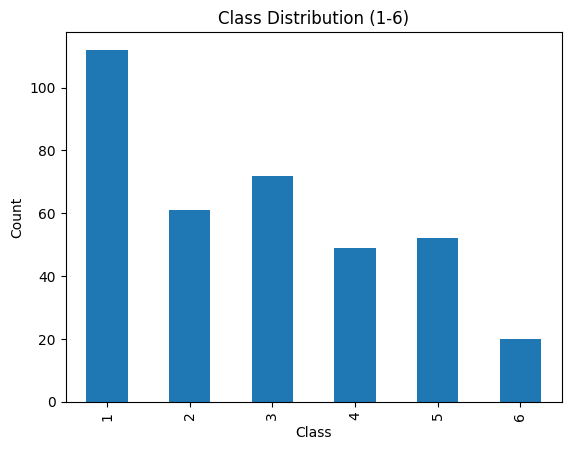

In [3]:
# 3. INSPECT MISSING VALUES & CLASS DISTRIBUTION
print("\nMissing values per column:")
print(df.isna().sum())

print("\nClass distribution (1-6, see UCI for disease types):")
print(df['class'].value_counts())

# Bar chart of class balance
df['class'].value_counts().sort_index().plot.bar(title="Class Distribution (1-6)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

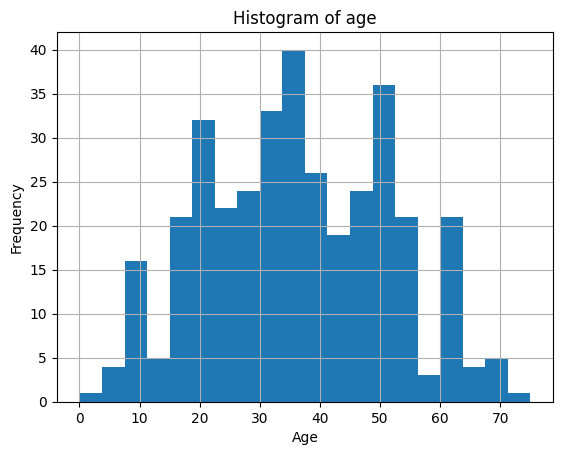

In [4]:
# 4. AGE FEATURE DISTRIBUTIONS
# Plot histograms for age feature since it has missing values
plt.figure()
df['age'].hist(bins=20)
plt.title(f"Histogram of age")
plt.xlabel('Age')
plt.ylabel("Frequency")
plt.show()

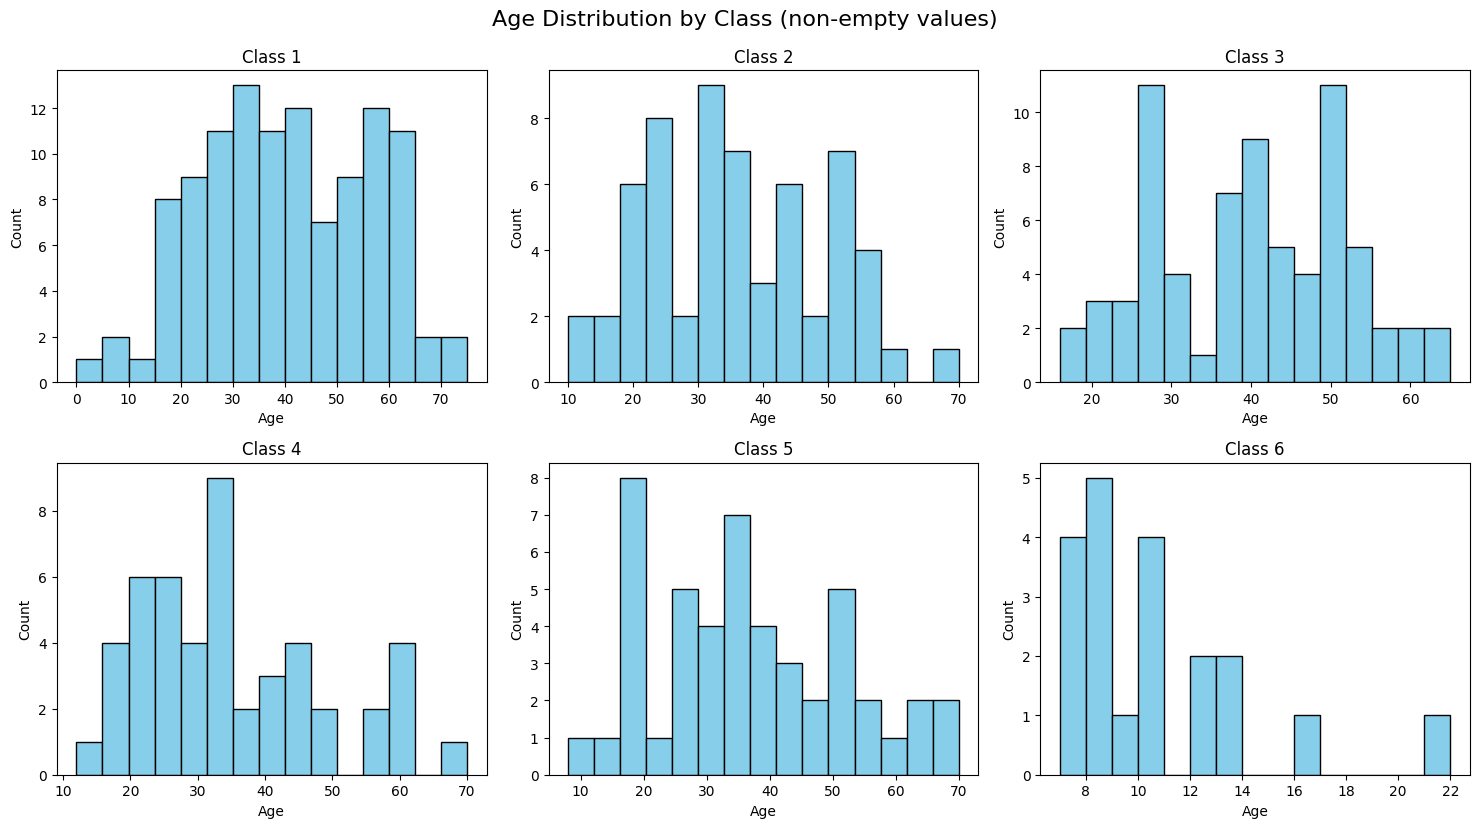

In [5]:
# CLASS-WISE AGE HISTOGRAM

plt.figure(figsize=(15, 8))
class_labels = sorted(df['class'].dropna().unique())
for idx, cls in enumerate(class_labels, 1):
    plt.subplot(2, 3, idx)
    plt.hist(df[df['class'] == cls]['age'].dropna(), bins=15, color='skyblue', edgecolor='black')
    plt.title(f'Class {cls}')
    plt.xlabel('Age')
    plt.ylabel('Count')
plt.tight_layout()
plt.suptitle('Age Distribution by Class (non-empty values)', fontsize=16, y=1.03)
plt.show()

The **age** feature, being a discrete numerical variable and typically regarded as a variable with a unimodal and approximately normal distribution, exhibits an unusually uneven distribution in its histogram. While the distribution peaks near the center, there are a considerable number of static values and outliers, particularly around the ages of *10*, *20*, *50*, and *60*. This phenomenon may be attributed to certain disease classes predominantly affecting specific age groups.

To address missing values in the *age* feature, we use **class-wise mode imputation**. Since diseases often affect particular age groups, imputing missing ages with the most common (mode) value within each class helps generalize the typical age for that disease. This approach is further justified because human age, given a sufficiently large sample, tends to follow a natural (almost normal) distribution—making the mode a reasonable representative for each class's age group.

In [6]:
# 5. IMPUTE MISSING VALUES CLASS-WISE FOR 'age'
X = df.drop('class', axis=1)
y = df['class']

X_imputed = X.copy()

# Impute 'age' by class-wise mode (most frequent value)
for cls in y.unique():
    mask = (y == cls)
    age_mode = X.loc[mask, 'age'].mode().iloc[0]  # mode() returns a Series
    X_imputed.loc[mask & X['age'].isna(), 'age'] = age_mode

# Verify no missing values remain
print("\nMissing after imputation:")
print(X_imputed.isna().sum())



Missing after imputation:
erythema                               0
scaling                                0
definite_borders                       0
itching                                0
koebner_phenomenon                     0
polygonal_papules                      0
follicular_papules                     0
oral_mucosal_involvement               0
knee_and_elbow_involvement             0
scalp_involvement                      0
family_history                         0
melanin_incontinence                   0
eosinophils_infiltrate                 0
PNL_infiltrate                         0
fibrosis_papillary_dermis              0
exocytosis                             0
acanthosis                             0
hyperkeratosis                         0
parakeratosis                          0
clubbing_rete_ridges                   0
elongation_rete_ridges                 0
thinning_suprapapillary_epidermis      0
spongiform_pustule                     0
munro_microabcess             

In [7]:
# 5.5. ONE-HOT ENCODING FOR CATEGORICAL FEATURES
# The dermatology dataset has categorical features (0-3 scale) that should be properly encoded
# We'll exclude 'age' from one-hot encoding as it's a continuous numerical feature

# Identify categorical columns (all except 'age')
categorical_cols = [col for col in X_imputed.columns if col != 'age']
continuous_cols = ['age']

print(f"Categorical features to encode: {len(categorical_cols)} features")
print(f"Continuous features to keep: {continuous_cols}")

# Apply one-hot encoding to categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid multicollinearity
X_categorical_encoded = encoder.fit_transform(X_imputed[categorical_cols])

# Create feature names for encoded columns
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create DataFrame with encoded categorical features
X_categorical_df = pd.DataFrame(X_categorical_encoded, columns=encoded_feature_names, index=X_imputed.index)

# Combine continuous features with encoded categorical features
X_final = pd.concat([X_imputed[continuous_cols], X_categorical_df], axis=1)

print(f"\nOriginal feature count: {X_imputed.shape[1]}")
print(f"Final feature count after one-hot encoding: {X_final.shape[1]}")
print(f"Shape of final dataset: {X_final.shape}")

# Display first few columns to verify encoding
print(f"\nFirst 5 columns of encoded dataset:")
print(X_final.iloc[:5, :5])

Categorical features to encode: 33 features
Continuous features to keep: ['age']

Original feature count: 34
Final feature count after one-hot encoding: 97
Shape of final dataset: (366, 97)

First 5 columns of encoded dataset:
    age  erythema_1  erythema_2  erythema_3  scaling_1
0  55.0         0.0         1.0         0.0        0.0
1   8.0         0.0         0.0         1.0        0.0
2  26.0         0.0         1.0         0.0        1.0
3  40.0         0.0         1.0         0.0        0.0
4  45.0         0.0         1.0         0.0        0.0


In [8]:
# 6. CREATE 16 SUBSETS FOR ALL TRAIN/TEST RATIOS (EXPLICIT VARIABLE NAMES)

# Shuffle the dataset first (using the one-hot encoded features)
X_shuffled, y_shuffled = shuffle(X_final, y, random_state=42)

# 40/60 split
feature_train_40_60, feature_test_40_60, label_train_40_60, label_test_40_60 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.4, test_size=0.6, stratify=y_shuffled, random_state=42
)
# 60/40 split
feature_train_60_40, feature_test_60_40, label_train_60_40, label_test_60_40 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.6, test_size=0.4, stratify=y_shuffled, random_state=42
)
# 80/20 split
feature_train_80_20, feature_test_80_20, label_train_80_20, label_test_80_20 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.8, test_size=0.2, stratify=y_shuffled, random_state=42
)
# 90/10 split
feature_train_90_10, feature_test_90_10, label_train_90_10, label_test_90_10 = train_test_split(
    X_shuffled, y_shuffled, train_size=0.9, test_size=0.1, stratify=y_shuffled, random_state=42
)

# Print sample sizes and class balance for each split
splits = [
    ("40/60", feature_train_40_60, feature_test_40_60, label_train_40_60, label_test_40_60),
    ("60/40", feature_train_60_40, feature_test_60_40, label_train_60_40, label_test_60_40),
    ("80/20", feature_train_80_20, feature_test_80_20, label_train_80_20, label_test_80_20),
    ("90/10", feature_train_90_10, feature_test_90_10, label_train_90_10, label_test_90_10),
]
for ratio, X_tr, X_te, y_tr, y_te in splits:
    print(f"\nSplit {ratio}:")
    print(f"  Train samples: {len(X_tr)}, Test samples: {len(X_te)}")
    print(f"  Feature dimensions: {X_tr.shape[1]} features")
    print("  Train class balance:")
    print(y_tr.value_counts(normalize=True))
    print("  Test class balance:")
    print(y_te.value_counts(normalize=True))

# Now you have 16 variables: feature_train_40_60, label_train_40_60, feature_test_40_60, label_test_40_60, etc.
# Each set corresponds to a different train/test split ratio, and all splits are stratified and shuffled.
# All feature sets now include one-hot encoded categorical variables.


Split 40/60:
  Train samples: 146, Test samples: 220
  Feature dimensions: 97 features
  Train class balance:
class
1    0.308219
3    0.198630
2    0.164384
5    0.143836
4    0.130137
6    0.054795
Name: proportion, dtype: float64
  Test class balance:
class
1    0.304545
3    0.195455
2    0.168182
5    0.140909
4    0.136364
6    0.054545
Name: proportion, dtype: float64

Split 60/40:
  Train samples: 219, Test samples: 147
  Feature dimensions: 97 features
  Train class balance:
class
1    0.305936
3    0.196347
2    0.168950
5    0.141553
4    0.132420
6    0.054795
Name: proportion, dtype: float64
  Test class balance:
class
1    0.306122
3    0.197279
2    0.163265
5    0.142857
4    0.136054
6    0.054422
Name: proportion, dtype: float64

Split 80/20:
  Train samples: 292, Test samples: 74
  Feature dimensions: 97 features
  Train class balance:
class
1    0.304795
3    0.195205
2    0.167808
5    0.143836
4    0.133562
6    0.054795
Name: proportion, dtype: float64
  Test cl

Class counts per class:
  Class 1: 112 samples
  Class 2: 61 samples
  Class 3: 72 samples
  Class 4: 49 samples
  Class 5: 52 samples
  Class 6: 20 samples
Class imbalance ratio (max/min): 112/20 = 5.60


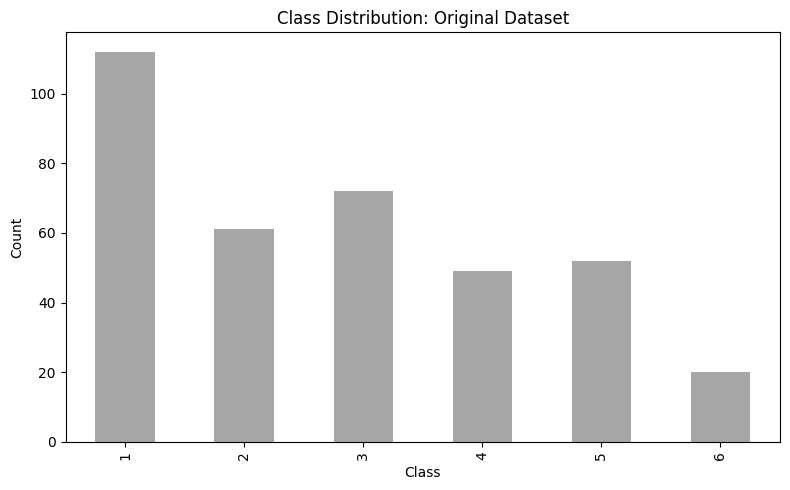

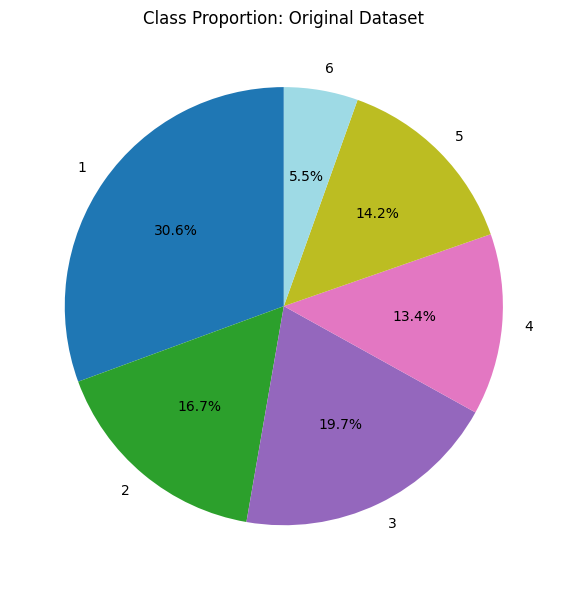

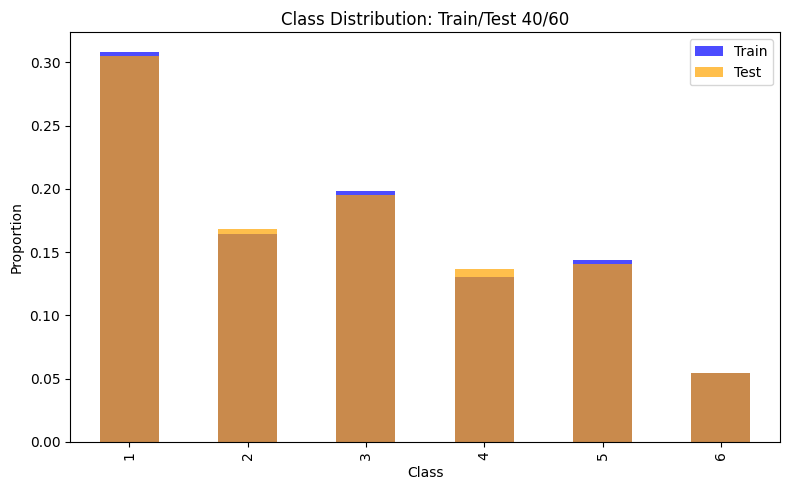

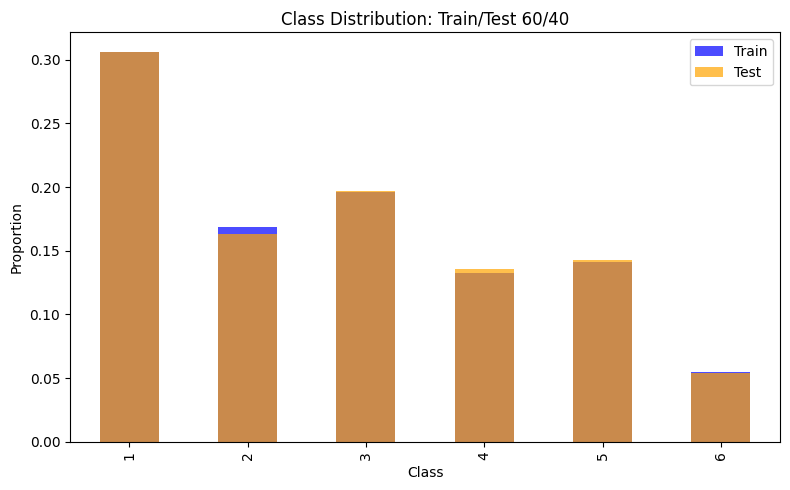

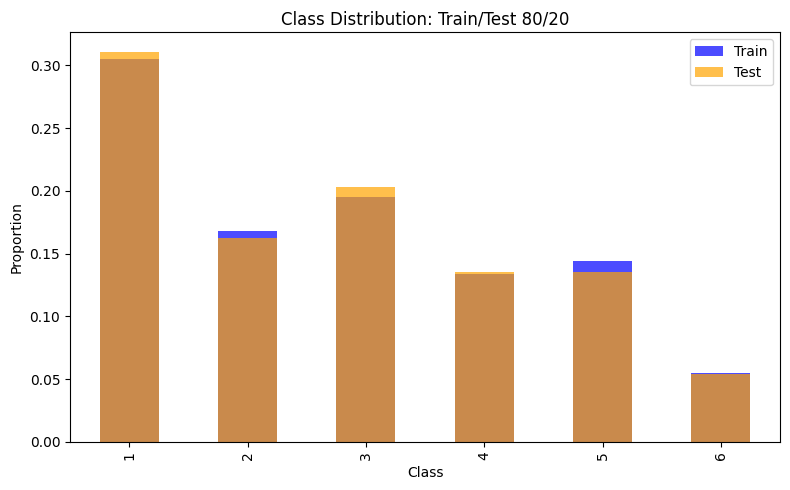

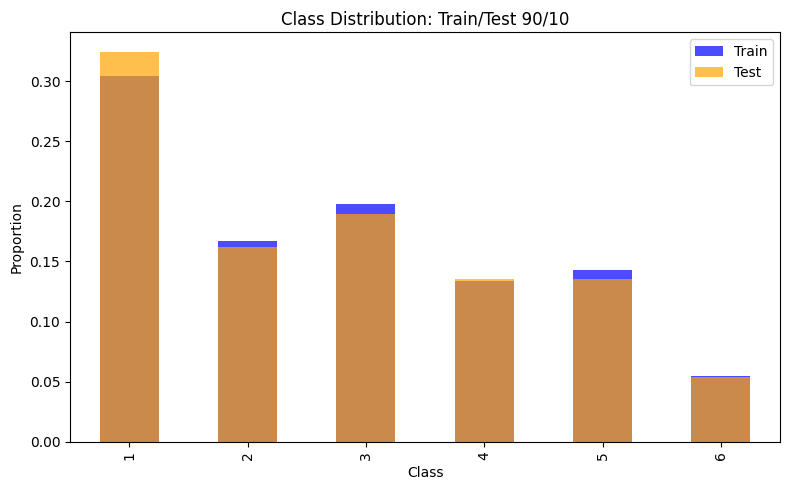

In [9]:
# 7. VISUALIZE CLASS DISTRIBUTIONS

splits = [
    ("40/60", label_train_40_60, label_test_40_60),
    ("60/40", label_train_60_40, label_test_60_40),
    ("80/20", label_train_80_20, label_test_80_20),
    ("90/10", label_train_90_10, label_test_90_10),
]

# Print class counts and imbalance ratio before visualization
print("Class counts per class:")
for cls, count in y.value_counts().sort_index().items():
    print(f"  Class {cls}: {count} samples")
imbalance_numerator = y.value_counts().max()
imbalance_denominator = y.value_counts().min()
imbalance_ratio = imbalance_numerator / imbalance_denominator
print(f"Class imbalance ratio (max/min): {imbalance_numerator}/{imbalance_denominator} = {imbalance_ratio:.2f}")

# Bar plot for class distribution (shows imbalance visually)
plt.figure(figsize=(8, 5))
y.value_counts().sort_index().plot(kind='bar', color='gray', alpha=0.7)
plt.title("Class Distribution: Original Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Pie chart for class proportions (optional, also shows imbalance)
plt.figure(figsize=(6, 6))
y.value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20')
plt.title("Class Proportion: Original Dataset")
plt.ylabel("")
plt.tight_layout()
plt.show()


# Plot train/test distributions for each split
for ratio, y_train, y_test in splits:
    plt.figure(figsize=(8, 5))
    y_train.value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.7, label='Train', color='blue')
    y_test.value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.7, label='Test', color='orange')
    plt.title(f"Class Distribution: Train/Test {ratio}")
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
# 8. CREATE & SAVE SPLIT SUMMARY REPORT

import os

output_dir = '../../results/additional_dataset'
os.makedirs(output_dir, exist_ok=True)

split_stats = []
splits = [
    ("40/60", label_train_40_60, label_test_40_60),
    ("60/40", label_train_60_40, label_test_60_40),
    ("80/20", label_train_80_20, label_test_80_20),
    ("90/10", label_train_90_10, label_test_90_10),
]

class_labels = sorted(y.unique())  # [1, 2, 3, 4, 5, 6]

for ratio, y_train, y_test in splits:
    row = {
        'Split Ratio': ratio,
        'Train Size': len(y_train),
        'Test Size': len(y_test),
    }
    for cls in class_labels:
        row[f'Train Class {cls}'] = (y_train == cls).sum()
        row[f'Test Class {cls}'] = (y_test == cls).sum()
    split_stats.append(row)

summary_df = pd.DataFrame(split_stats)
summary_path = os.path.join(output_dir, 'split_summary.csv')
summary_df.to_csv(summary_path, index=False)
print(f"✅ Summary saved to {summary_path}")

# Display summary
print("\nSplit Summary:")
print(summary_df)

✅ Summary saved to ../../results/additional_dataset\split_summary.csv

Split Summary:
  Split Ratio  Train Size  Test Size  Train Class 1  Test Class 1  \
0       40/60         146        220             45            67   
1       60/40         219        147             67            45   
2       80/20         292         74             89            23   
3       90/10         329         37            100            12   

   Train Class 2  Test Class 2  Train Class 3  Test Class 3  Train Class 4  \
0             24            37             29            43             19   
1             37            24             43            29             29   
2             49            12             57            15             39   
3             55             6             65             7             44   

   Test Class 4  Train Class 5  Test Class 5  Train Class 6  Test Class 6  
0            30             21            31              8            12  
1            20          

**Next Steps:**  
After running this data preparation script _(reaching here)_, please proceed to `03_additional_dataset_models_evaluation.ipynb` to create and evaluate classification models.  
**Important:** These two notebooks are designed to be used within the same session to ensure all variables and data splits remain available for modeling and evaluation.